In [172]:
# Load and read Diabetes Data from the URL

import pandas as pd
from sklearn.datasets import load_svmlight_file
import requests
from io import BytesIO

# Read the original diabetes data downloaded from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data
df = pd.read_csv('diabetes.csv')

# show the shape data
print("Diabetes data shape: ", df.shape)

# Display the first few rows of the data
print(df.head())

# Download the scaled preprocessed data from the URL
url = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes_scale'
response = requests.get(url)
data = BytesIO(response.content)

# Load the LIBSVM scaled data of diabetes (between +1 and -1)
X,y = load_svmlight_file(data)
X = X.toarray() # To convert X to NumPy array

# Convert the loaded datato a dataframe
df_scaled = pd.DataFrame(X)
df_scaled['class_id']= y

# show the shape scaled preproceesed data
print("\nScaled preprocessed diabetes data shape: ", df_scaled.shape)

# Display the DataFrame
df_scaled.head()

Diabetes data shape:  (768, 9)
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Scaled preprocessed diabetes data shape:  (768, 9)


,0,1,2,3,4,5,6,7,class_id
0,-0.294118,0.487437,0.180328,-0.292929,-1.000000,0.001490,-0.531170,-0.033333,-1.0
1,-0.882353,-0.145729,0.081967,-0.414141,-1.000000,-0.207153,-0.766866,-0.666667,1.0
2,-0.058824,0.839196,0.049180,-1.000000,-1.000000,-0.305514,-0.492741,-0.633333,-1.0
3,-0.882353,-0.105528,0.081967,-0.535354,-0.777778,-0.162444,-0.923997,-1.000000,1.0
4,-1.000000,0.376884,-0.344262,-0.292929,-0.602837,0.284650,0.887276,-0.600000,-1.0


In [419]:
# To initialiaze the perceptron algorithm using classes

import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score

# First, we split the dataset into 80% training and 20% test sets
np.random.seed(0)  # For reproducibility
indices = np.random.permutation(len(y))
split_index = int(0.8 * len(y))
train_indices, test_indices = indices[:split_index], indices[split_index:]

X_train_full, X_test = X[train_indices], X[test_indices]
y_train_full, y_test = y[train_indices], y[test_indices]

# Then we split the 80% training set into 70% training and 10% validation
val_split_index = int(0.875 * len(y_train_full))  # 0.875 * 80% = 70%
train_indices, val_indices = train_indices[:val_split_index], train_indices[val_split_index:]

X_train, X_val = X[train_indices], X[val_indices]
y_train, y_val = y[train_indices], y[val_indices]

# To implement the Perceptron Algorithm using a class

class Perceptron:
    def __init__(self, learning_rate=0.01, n_iters=500):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.weight_history = [] # To track weight during the training process
        self.bias_history = []  # To track bias during the training process
        self.train_acc_history = []  # To track training accuracy
        self.val_acc_history = []  # To track validation accuracy
        self.train_loss_history = []  # To track training loss
        self.val_loss_history = []  # To track validation loss
    
    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape
        # To initialize weights and bias
        self.weights = np.random.randn(n_features) * 0.01 # to Strat with a small value of weight to allow for updating
        #self.weights = np.zeros(n_features)
        self.bias = 0
        
        # For the training process by dot multiplying the input features with weights and adding bias
        for _ in range(self.n_iters):
            total_loss = 0  # To initialize total loss for training data
            for i, x_i in enumerate(X):
                output = np.dot(x_i, self.weights)+self.bias
                y_pred = np.sign(output)

                # To calculate loss for the current sample
                loss = max(0, -y[i] * output)
                total_loss += loss
                
                # To update weights by w = w + learning_rate * y_i * x_i
                if y[i] * output <= 0: 
                    self.weights += self.learning_rate * y[i] * x_i
                    self.bias += self.learning_rate * y[i]
            # To store the current weights and bias after each iteration
            self.weight_history.append(self.weights.copy())
            self.bias_history.append(self.bias)

            # To calculate and store training accuracy
            train_preds = self.predict(X)
            train_acc = np.mean(train_preds == y)
            self.train_acc_history.append(train_acc)

            # To store the average training loss for this iteration
            avg_train_loss = total_loss / n_samples
            self.train_loss_history.append(avg_train_loss)

            # To alculate and store validation accuracy
            if X_val is not None and y_val is not None:
                val_preds = self.predict(X_val)
                val_acc = np.mean(val_preds == y_val)
                self.val_acc_history.append(val_acc)

                # To calculate validation loss using the same loss function
                val_loss = np.mean([max(0, -y_val[i] * (np.dot(X_val[i], self.weights) + self.bias)) for i in range(len(y_val))])
                self.val_loss_history.append(val_loss)
                
    def predict(self, X):
        output = np.dot(X, self.weights) + self.bias
        return np.sign(output)


In [525]:
# To train the basic Perceptron model 
learning_rate=0.0001
n_iters= 40
perceptron_1 = Perceptron(learning_rate=learning_rate, n_iters=n_iters)
perceptron_1.fit(X_train, y_train, X_val=X_val, y_val=y_val)

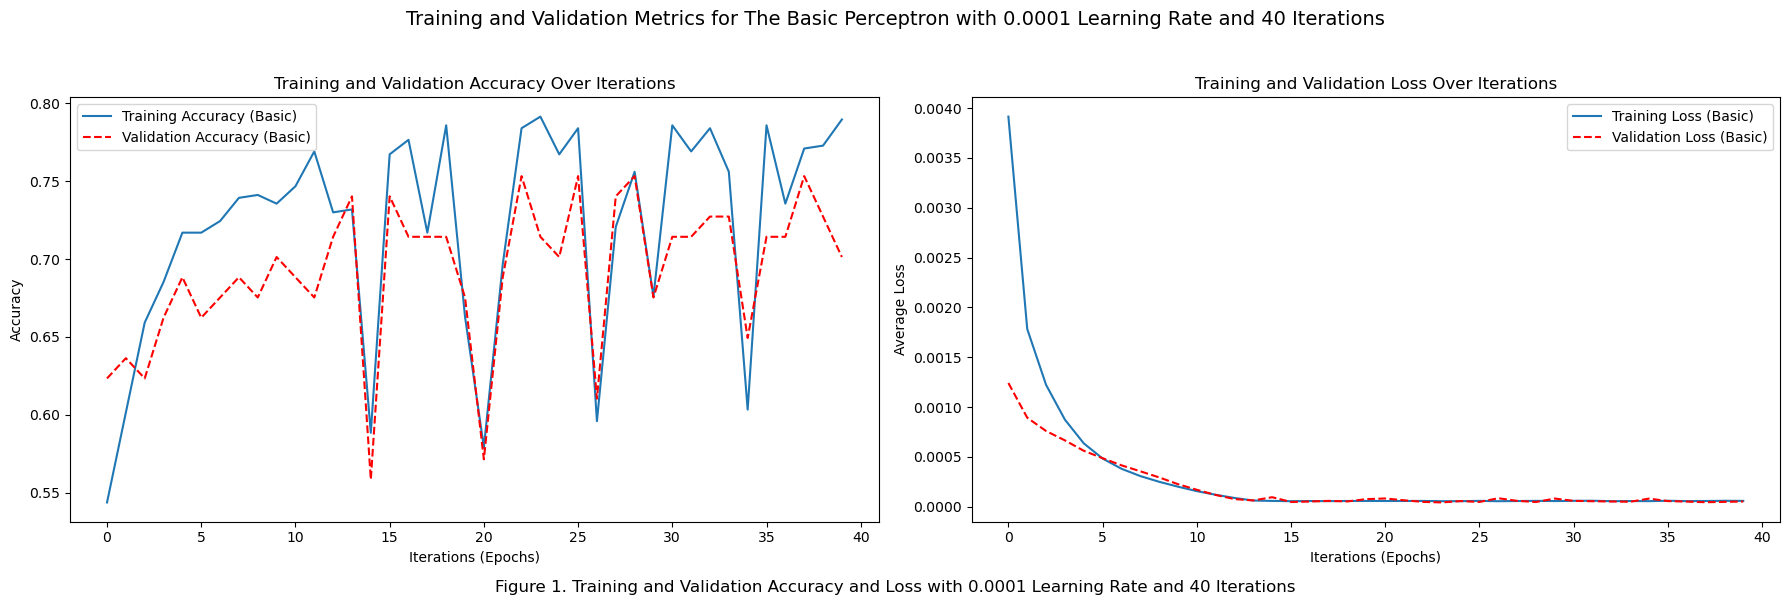

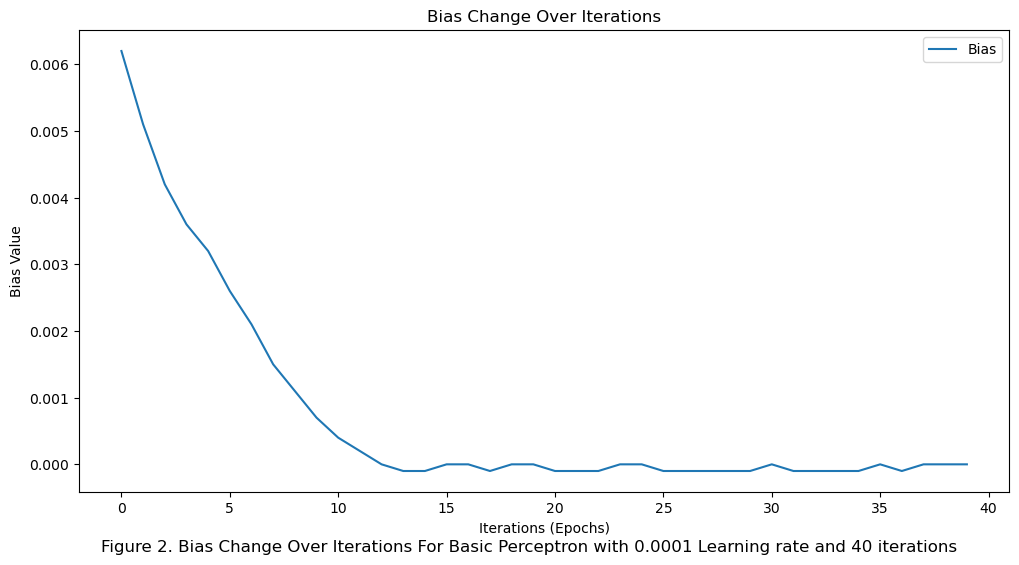

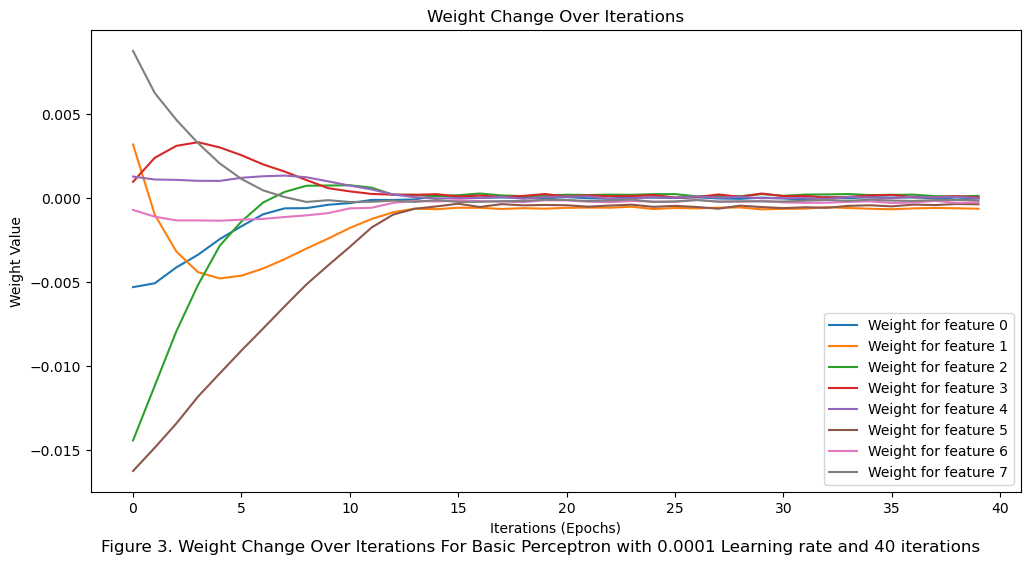

In [526]:
# Basic Perceptron Visualization

import matplotlib.pyplot as plt

# To plot Training and Validation Accracy & Loss
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(perceptron_1.train_acc_history, label='Training Accuracy (Basic)')
ax[0].plot(perceptron_1.val_acc_history, label='Validation Accuracy (Basic)', linestyle='--', color='red')
ax[0].set_title('Training and Validation Accuracy Over Iterations')
ax[0].set_xlabel('Iterations (Epochs)')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(perceptron_1.train_loss_history, label='Training Loss (Basic)')
ax[1].plot(perceptron_1.val_loss_history, label='Validation Loss (Basic)', linestyle='--', color='red')
ax[1].set_title('Training and Validation Loss Over Iterations')
ax[1].set_xlabel('Iterations (Epochs)')
ax[1].set_ylabel('Average Loss')
ax[1].legend()
fig.suptitle(f'Training and Validation Metrics for The Basic Perceptron with {learning_rate} Learning Rate and {n_iters} Iterations', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit figure text
plt.figtext(0.5, 0.01, f'Figure 1. Training and Validation Accuracy and Loss with {learning_rate} Learning Rate and {n_iters} Iterations', ha='center', fontsize=12)
plt.show()

# To plot bias change over iterations
plt.figure(figsize=(12, 6))
plt.plot(perceptron_1.bias_history, label='Bias')
plt.title('Bias Change Over Iterations')
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Bias Value')
plt.legend()
plt.figtext(0.5, 0.01, f'Figure 2. Bias Change Over Iterations For Basic Perceptron with {learning_rate} Learning rate and {n_iters} iterations', ha='center', fontsize=12)
plt.show()

# To convert weight change history to a numpy array for plotting
weight_history = np.array(perceptron_1.weight_history)

# To plot weight change for each feature over iterations
plt.figure(figsize=(12, 6))
for i in range(weight_history.shape[1]):
    plt.plot(weight_history[:, i], label=f'Weight for feature {i}')
plt.title('Weight Change Over Iterations')
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Weight Value')
plt.legend()
plt.figtext(0.5, 0.01, f'Figure 3. Weight Change Over Iterations For Basic Perceptron with {learning_rate} Learning rate and {n_iters} iterations', ha='center', fontsize=12)
plt.show()


In [527]:
# To produce predictions based on the test set
y_test_pred = perceptron_1.predict(X_test)

# To evaluate the perceptron model's performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the evaluation results for the basic Perceptron model
print(f"\nThe model's test evaluation results with {learning_rate} learning rate and {n_iters} iterations")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")


The model's test evaluation results with 0.0001 learning rate and 40 iterations
Accuracy: 0.7857142857142857
Precision: 0.8157894736842105
Recall: 0.8857142857142857
Confusion Matrix:
[[28 21]
 [12 93]]


In [462]:
# To improve the basic Perceptron using ERM

class PerceptronERM:
    def __init__(self, learning_rate=0.01, n_iters=500):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        self.weight_history = []  # To track weight during the training process
        self.bias_history = []  # To track bias during the training process
        self.train_acc_history = []  # To track training accuracy
        self.val_acc_history = []  # To track validation accuracy
        self.train_loss_history = []  # To track training loss (ERM)
        self.val_loss_history = []  # To track validation loss (ERM)

    def fit(self, X, y, X_val=None, y_val=None):
        n_samples, n_features = X.shape
        # Initialize weights and bias
        self.weights = np.random.randn(n_features) * 0.01 # to Strat with a small value of weight to allow for updating
        self.bias = 0

        # For the training process
        for _ in range(self.n_iters):
            total_loss = 0  # To initilize te total loss over all samples

            # Initialize gradient accumulators for weights and bias
            weight_grad = np.zeros(n_features)
            bias_grad = 0

            for i, x_i in enumerate(X):
                output = np.dot(x_i, self.weights) + self.bias

                # To calculate the Perceptron loss: max(0, -y_i * (w · x_i + b))
                loss = max(0, -y[i] * output)
                total_loss += loss  # To sum the the loss for each iteration

                # To sum gradients for misclassified samples (sub-gradient)
                if loss > 0:  # This indicates that y_i * (w · x_i + b) < 0
                    weight_grad += -y[i] * x_i
                    bias_grad += -y[i]

            # To update weights and bias using the average sub gradient
            self.weights -= self.learning_rate * (weight_grad / n_samples)
            self.bias -= self.learning_rate * (bias_grad / n_samples)

            # Store the current weights and bias after each iteration
            self.weight_history.append(self.weights.copy())
            self.bias_history.append(self.bias)

            # Store the average empirical risk which represents the mean loss for the current iteration
            avg_loss = total_loss / n_samples
            self.train_loss_history.append(avg_loss)

            # To caalculate and store training accuracy
            train_preds = self.predict(X)
            train_acc = np.mean(train_preds == y)
            self.train_acc_history.append(train_acc)

            # To calculate and store validation accuracy
            if X_val is not None and y_val is not None:
                val_preds = self.predict(X_val)
                val_acc = np.mean(val_preds == y_val)
                self.val_acc_history.append(val_acc)

                # To calculate validation loss using the same ERM loss function
                val_loss = np.mean([max(0, -y_val[i] * (np.dot(X_val[i], self.weights) + self.bias)) for i in range(len(y_val))])
                self.val_loss_history.append(val_loss)
    
    def predict(self, X):
        output = np.dot(X, self.weights) + self.bias
        return np.sign(output)

In [545]:
# To train the ERM perceptron model with 0.01 learning rate and 100 iterations
learning_rate=0.0001
n_iters= 5000
perceptron_2 = PerceptronERM(learning_rate=learning_rate, n_iters=n_iters)
perceptron_2.fit(X_train, y_train, X_val=X_val, y_val=y_val)

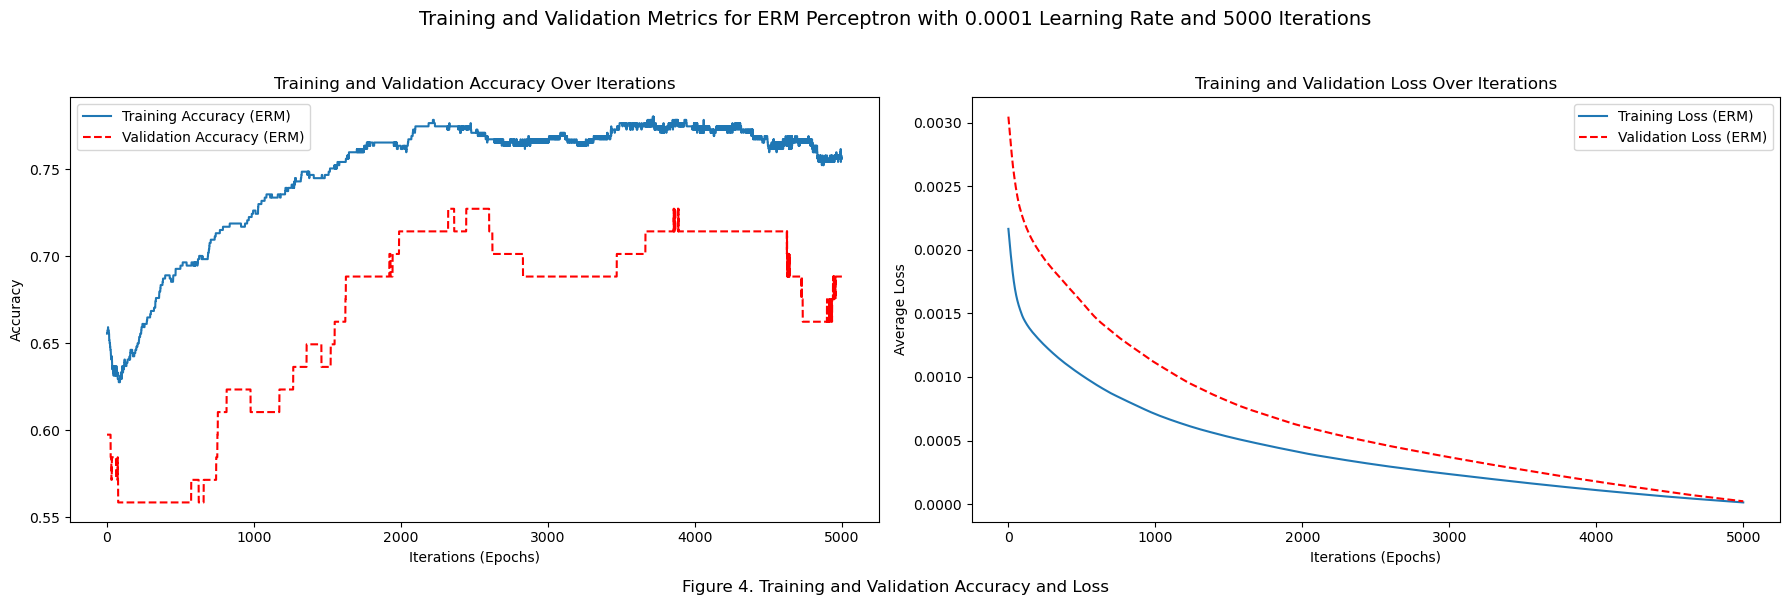

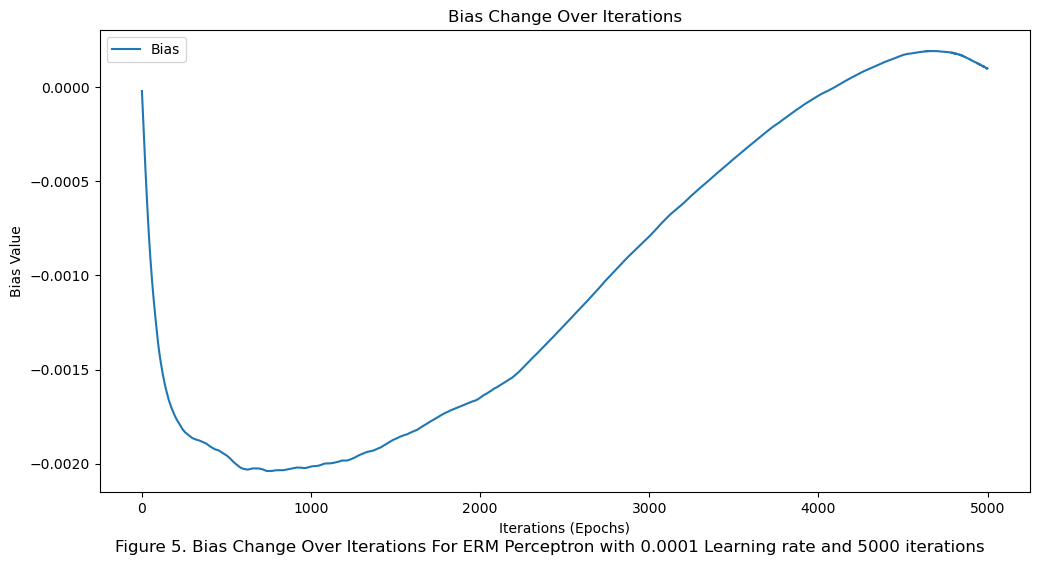

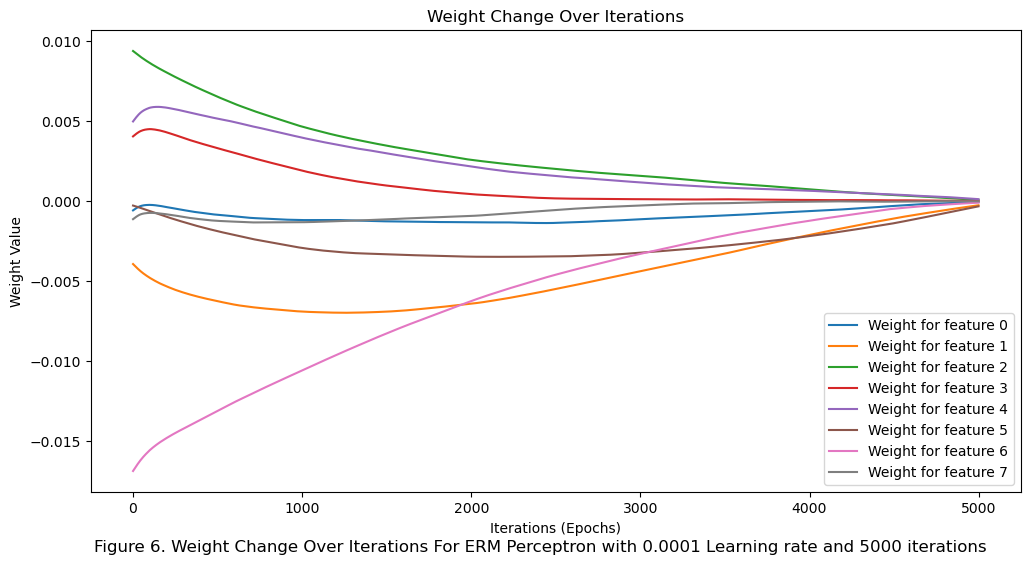

In [546]:
# Plots for ERM Perceptron Visualization

import matplotlib.pyplot as plt

# To plot Training and Validation Accracy & Loss
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(perceptron_2.train_acc_history, label='Training Accuracy (ERM)')
ax[0].plot(perceptron_2.val_acc_history, label='Validation Accuracy (ERM)', linestyle='--', color='red')
ax[0].set_title('Training and Validation Accuracy Over Iterations')
ax[0].set_xlabel('Iterations (Epochs)')
ax[0].set_ylabel('Accuracy')
ax[0].legend()
ax[1].plot(perceptron_2.train_loss_history, label='Training Loss (ERM)')
ax[1].plot(perceptron_2.val_loss_history, label='Validation Loss (ERM)', linestyle='--', color='red')
ax[1].set_title('Training and Validation Loss Over Iterations')
ax[1].set_xlabel('Iterations (Epochs)')
ax[1].set_ylabel('Average Loss')
ax[1].legend()
fig.suptitle(f'Training and Validation Metrics for ERM Perceptron with {learning_rate} Learning Rate and {n_iters} Iterations', fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit figure text
plt.figtext(0.5, 0.01, 'Figure 4. Training and Validation Accuracy and Loss', ha='center', fontsize=12)
plt.show()

# To plot bias change over iterations
plt.figure(figsize=(12, 6))
plt.plot(perceptron_2.bias_history, label='Bias')
plt.title('Bias Change Over Iterations')
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Bias Value')
plt.legend()
plt.figtext(0.5, 0.01, f'Figure 5. Bias Change Over Iterations For ERM Perceptron with {learning_rate} Learning rate and {n_iters} iterations', ha='center', fontsize=12)
plt.show()

# Convert weight change history to a numpy array for plotting
weight_history = np.array(perceptron_2.weight_history)

# To plot weight change for each feature over iterations
plt.figure(figsize=(12, 6))
for i in range(weight_history.shape[1]):
    plt.plot(weight_history[:, i], label=f'Weight for feature {i}')
plt.title('Weight Change Over Iterations')
plt.xlabel('Iterations (Epochs)')
plt.ylabel('Weight Value')
plt.legend()
plt.figtext(0.5, 0.01, f'Figure 6. Weight Change Over Iterations For ERM Perceptron with {learning_rate} Learning rate and {n_iters} iterations', ha='center', fontsize=12)
plt.show()

In [547]:
# ERM Perceptron Test Evaluation

# To produce predictions based on the test set
y_test_pred = perceptron_2.predict(X_test)

# To evaluate the perceptron model's performance
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, pos_label=1)
recall = recall_score(y_test, y_test_pred, pos_label=1)
conf_matrix = confusion_matrix(y_test, y_test_pred)

# Display the evaluation results with learning rate = 0.01 and 500 iterations
print(f"\nThe ERM Perceptrons model's test evaluation results with {learning_rate} learning rate and {n_iters} iterations")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Confusion Matrix:\n{conf_matrix}")


The ERM Perceptrons model's test evaluation results with 0.0001 learning rate and 5000 iterations
Accuracy: 0.7922077922077922
Precision: 0.8288288288288288
Recall: 0.8761904761904762
Confusion Matrix:
[[30 19]
 [13 92]]
